In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

Training Model 1...
Epoch 0, Loss: 5.2042
Epoch 100, Loss: 2.6053
Epoch 200, Loss: 2.5042
Epoch 300, Loss: 2.6517
Epoch 400, Loss: 2.4761
Epoch 500, Loss: 2.4840
Epoch 600, Loss: 2.1386
Epoch 700, Loss: 2.3059
Epoch 800, Loss: 2.4202
Epoch 900, Loss: 2.4191

Training Model 2...
Epoch 0, Loss: 5.2327
Epoch 100, Loss: 2.5087
Epoch 200, Loss: 2.6836
Epoch 300, Loss: 2.4246
Epoch 400, Loss: 2.4247
Epoch 500, Loss: 2.4221
Epoch 600, Loss: 2.4012
Epoch 700, Loss: 2.3346
Epoch 800, Loss: 2.2311
Epoch 900, Loss: 2.1691


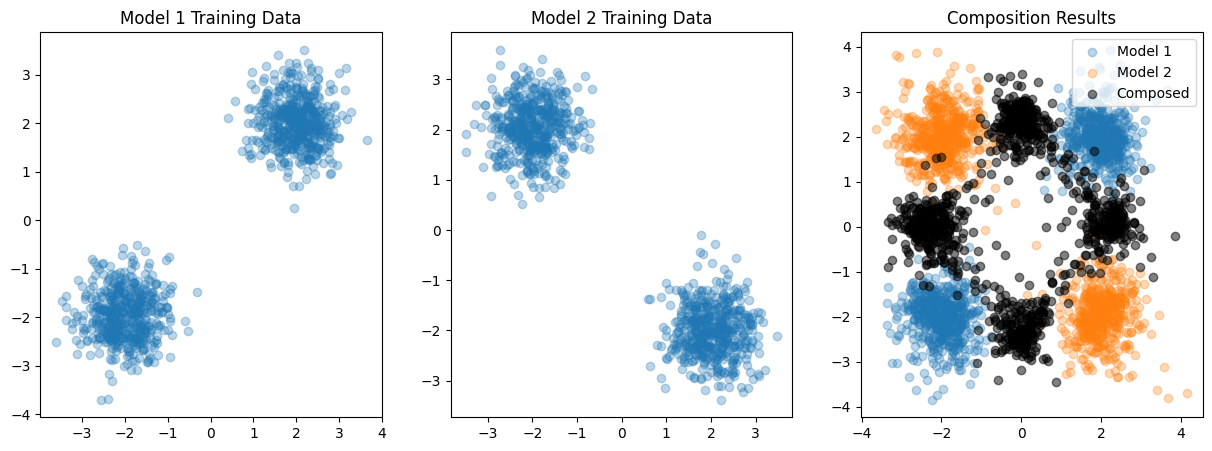

In [ ]:
class VectorFieldMLP(nn.Module):
    def __init__(self, dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, dim)
        )

    def forward(self, x, t):
        return self.net(torch.cat([x, t.view(-1, 1)], -1))

class FlowMatching:
    def __init__(self, dim, device='cuda'):
        self.device = torch.device(device)
        self.vf_net = VectorFieldMLP(dim).to(self.device)
        self.loss_fn = nn.MSELoss()
        
    def train_model(self, data, epochs=1000, lr=1e-3):
        optimizer = optim.Adam(self.vf_net.parameters(), lr=lr)
        for epoch in range(epochs):
            x0 = torch.randn_like(data)
            t = torch.rand(len(data), 1, device=self.device)
            xt = (1 - t)*x0 + t*data
            vt = self.vf_net(xt, t.squeeze())
            loss = self.loss_fn(vt, data - x0)
             
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    def sample(self, num_samples=1000, steps=100):
        x = torch.randn(num_samples, 2, device=self.device)
        with torch.no_grad():
            for t in torch.linspace(0, 1, steps, device=self.device):
                dt = 1/steps
                x += self.vf_net(x, t.expand(len(x))) * dt
        return x.cpu()

In [ ]:
def create_data(centers, num_samples=500):
    return torch.cat([
        torch.randn(num_samples, 2) * 0.5 + torch.tensor(c) 
        for c in centers
    ]).cuda()
class ComposedFlow:
    def __init__(self, models):
        self.models = models
        
    def forward(self, x, t):
        out = 0
        for model in self.models: 
            out += model.vf_net(x,t.expand(len(x)))
        return out
        
    def additive_samples(self, num_samples=1000, steps=100):
        x = torch.randn(num_samples, 2).cuda()
        with torch.no_grad():
            for t in torch.linspace(0, 1, steps, device='cuda'):
                dt = 1/steps
                v = self.forward(x,t)/len(self.models)
                x += v * dt
        return x.cpu()
    
    def alternating_samples(self, num_samples=1000, steps=100):
        x = torch.randn(num_samples, 2).cuda()
        with torch.no_grad():
            i = 0
            for t in torch.linspace(0, 1, steps, device='cuda'):
                dt = 1/steps
                v = self.models[i % len(self.models)].vf_net(x, t.expand(len(x)))
                x += v * dt
                i += 1
        return x.cpu()

In [ ]:
model1 = FlowMatching(2)
model2 = FlowMatching(2)

print("Training Model 1...")
data1 = create_data([(2,2), (-2,-2)])
model1.train_model(data1, epochs=1000)

print("\nTraining Model 2...")
data2 = create_data([(2,-2), (-2,2)])
model2.train_model(data2, epochs=1000)

samples1 = model1.sample()
samples2 = model2.sample()
composed_model = ComposedFlow([model1, model2])
composed_samples = composed_model.alternating_samples()

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.scatter(data1.cpu()[:,0], data1.cpu()[:,1], alpha=0.3)
plt.title("Model 1 Training Data")

plt.subplot(132)
plt.scatter(data2.cpu()[:,0], data2.cpu()[:,1], alpha=0.3)
plt.title("Model 2 Training Data")

plt.subplot(133)
plt.scatter(samples1[:,0], samples1[:,1], alpha=0.3, label='Model 1')
plt.scatter(samples2[:,0], samples2[:,1], alpha=0.3, label='Model 2')
plt.scatter(composed_samples[:,0], composed_samples[:,1], alpha=0.5, 
            color='black', label='Composed')
plt.legend()
plt.title("Composition Results")
plt.show()

In [ ]:
class FlowAnimator:
    def __init__(self, models):
        self.models = models
        self.composer = ComposedFlow(models)
        self.device = models[0].device
        
    def _get_trajectories(self, num_samples=500, steps=100):
        x0 = torch.randn(num_samples, 2, device=self.device)
        
        # Store trajectories for all models and the ocposition
        trajs = {
            'model1': torch.zeros(steps+1, num_samples, 2),
            'model2': torch.zeros(steps+1, num_samples, 2),
            'composed': torch.zeros(steps+1, num_samples, 2)
        }
        
        trajs['model1'][0] = x0.cpu()
        trajs['model2'][0] = x0.cpu()
        trajs['composed'][0] = x0.cpu()
        
        with torch.no_grad():
            for i, t in enumerate(np.linspace(0, 1, steps)):
                dt = 1/steps
                
                x1 = trajs['model1'][i].to(self.device)
                v1 = self.models[0].vf_net(x1, torch.full((num_samples,), t, device=self.device))
                trajs['model1'][i+1] = (x1 + v1 * dt).cpu()
                
                x2 = trajs['model2'][i].to(self.device)
                v2 = self.models[1].vf_net(x2, torch.full((num_samples,), t, device=self.device))
                trajs['model2'][i+1] = (x2 + v2 * dt).cpu()
                
                xc = trajs['composed'][i].to(self.device)
                vc = (v1 + v2)/2
                trajs['composed'][i+1] = (xc + vc * dt).cpu()
                
        return trajs

    def animate_flows(self, num_samples=300, steps=100):
        trajs = self._get_trajectories(num_samples, steps)
        
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle("Flow Matching Composition Process", fontsize=14)
        
        scat1 = ax[0].scatter([], [], s=10, alpha=0.5, c='blue')
        scat2 = ax[1].scatter([], [], s=10, alpha=0.5, c='orange') 
        scatc = ax[2].scatter([], [], s=10, alpha=0.5, c='green')
        
        # Format the subplots
        titles = ['Model 1 Flow', 'Model 2 Flow', 'Composed Flow']
        for a, t in zip(ax, titles):
            a.set_xlim(-4, 4)
            a.set_ylim(-4, 4)
            a.set_title(t)
            a.grid(True)
        
        def update(frame):
            scat1.set_offsets(trajs['model1'][frame])
            scat2.set_offsets(trajs['model2'][frame])
            scatc.set_offsets(trajs['composed'][frame])
            return scat1, scat2, scatc
        
        anim = FuncAnimation(fig, update, frames=range(0, steps+1, 2), 
                            interval=50, blit=True)
        plt.close()
        return anim

animator = FlowAnimator([model1, model2])
animation = animator.animate_flows(num_samples=300, steps=100)

# Save gif
animation.save('flow_composition.gif', writer='pillow', dpi=100)

# display inline
#from IPython.display import HTML
#HTML(animation.to_jshtml())